**Customer segmentation Project**

Identificazione di cluster tra i clienti di un una compagnia automobilistica

Fonte dataset : https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation?select=train.csv

In [1]:
#varie librerie
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

EDA e PRE-PROCESSING

Analisi esplorativa dei dati e preparazione dei dati stessi per il successivo clustering con appositi algoritmi

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/DatasetProjects/automotivecompanytraincustomer.csv')
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 8068


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [5]:
d=data.drop(['Segmentation','Var_1','ID'], axis = 1) #tolgo le features che non servono


check dei missing values

In [6]:
d.isnull().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

In [7]:
d.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
dtype: int64

Ho visto che molti dati sono mancanti, in particolare anche su colonne con valore booleano o comunque dove assegnare uno 0 al posto del Nan non ha molto senso, pertanto elimino tutte le righe con almeno un valore nullo


In [8]:
d=d.dropna()

In [9]:
d.info() #controllo che siano stati eliminati tutte le righe con Nan

<class 'pandas.core.frame.DataFrame'>
Index: 6718 entries, 0 to 8067
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6718 non-null   object 
 1   Ever_Married     6718 non-null   object 
 2   Age              6718 non-null   int64  
 3   Graduated        6718 non-null   object 
 4   Profession       6718 non-null   object 
 5   Work_Experience  6718 non-null   float64
 6   Spending_Score   6718 non-null   object 
 7   Family_Size      6718 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 472.4+ KB


vediamo le distribuzioni delle features

In [10]:
print("Total categories in the feature working experience:\n", d["Work_Experience"].value_counts(), "\n")
print("Total categories in the feature Spending_Score:\n", d["Spending_Score"].value_counts(), "\n")
print("Total categories in the feature  Family_Size :\n", d["Family_Size"].value_counts(), "\n")
print("Total categories in the feature  Ever_Married :\n", d["Ever_Married"].value_counts(), "\n")
print("Total categories in the feature  Graduated :\n", d["Graduated"].value_counts(), "\n")
print("Total categories in the feature  Gender :\n", d["Gender"].value_counts(), "\n")
print("Total categories in the feature profession:\n", d["Profession"].value_counts())

Total categories in the feature working experience:
 Work_Experience
1.0     2204
0.0     2150
9.0      446
8.0      403
2.0      260
3.0      237
4.0      235
7.0      187
6.0      187
5.0      181
10.0      51
11.0      46
12.0      45
13.0      43
14.0      43
Name: count, dtype: int64 

Total categories in the feature Spending_Score:
 Spending_Score
Low        4029
Average    1677
High       1012
Name: count, dtype: int64 

Total categories in the feature  Family_Size :
 Family_Size
2.0    2109
3.0    1302
1.0    1251
4.0    1184
5.0     531
6.0     180
7.0      81
8.0      42
9.0      38
Name: count, dtype: int64 

Total categories in the feature  Ever_Married :
 Ever_Married
Yes    3975
No     2743
Name: count, dtype: int64 

Total categories in the feature  Graduated :
 Graduated
Yes    4278
No     2440
Name: count, dtype: int64 

Total categories in the feature  Gender :
 Gender
Male      3702
Female    3016
Name: count, dtype: int64 

Total categories in the feature profession

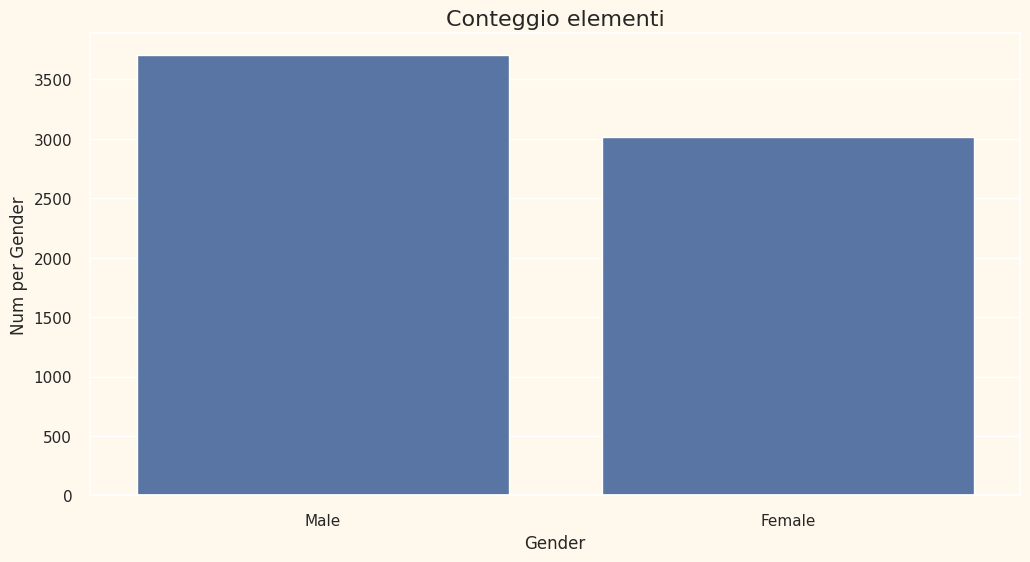

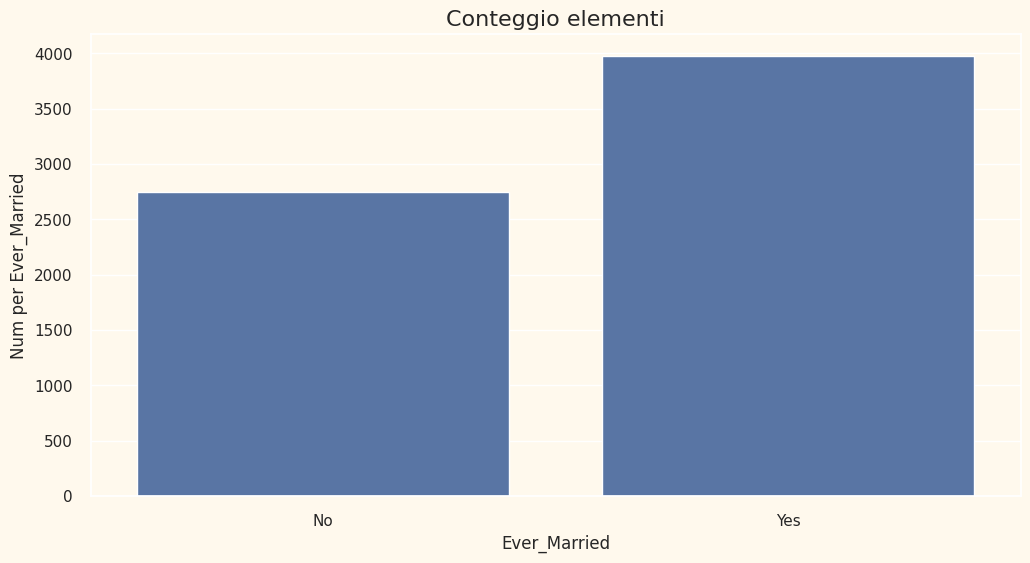

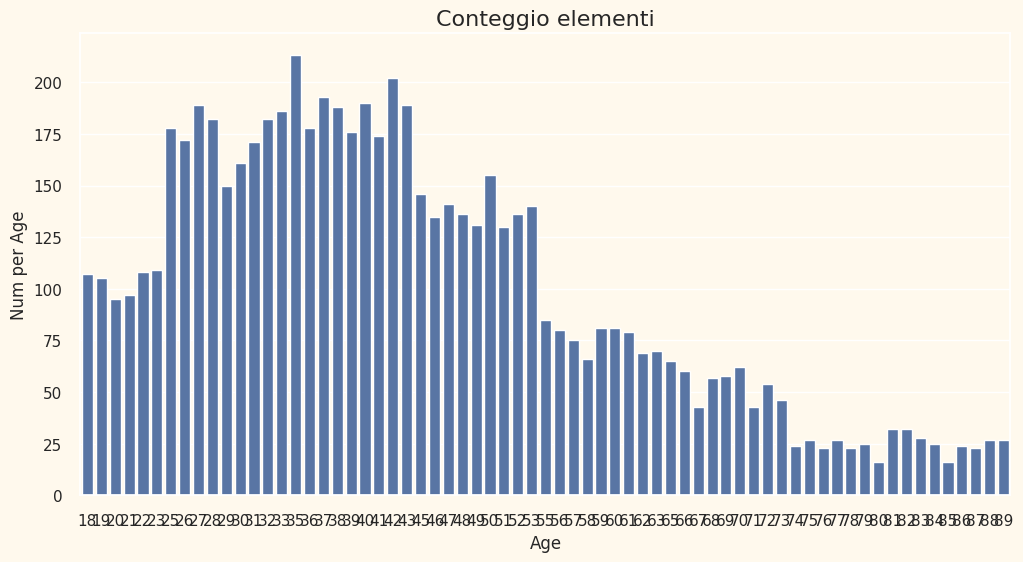

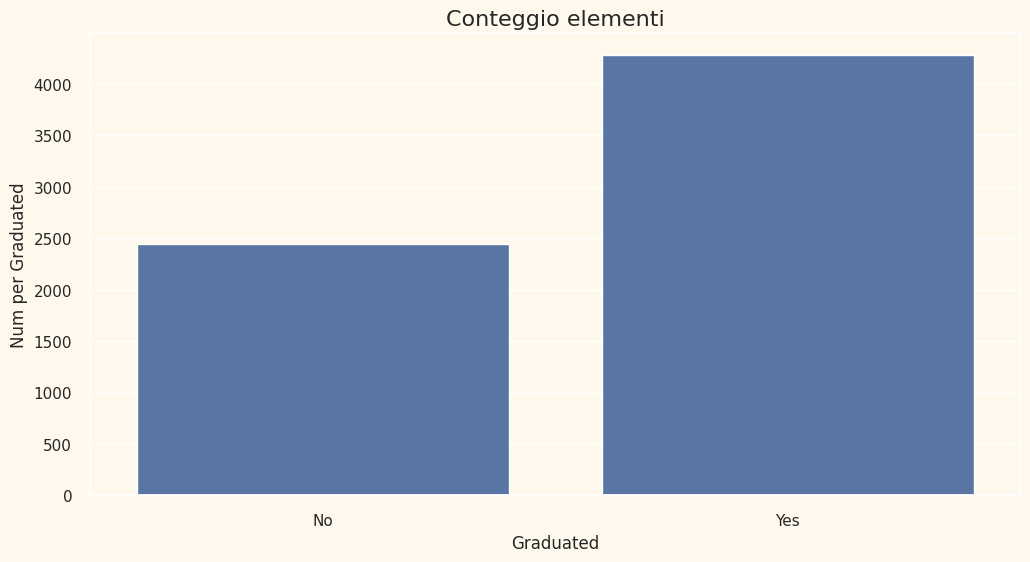

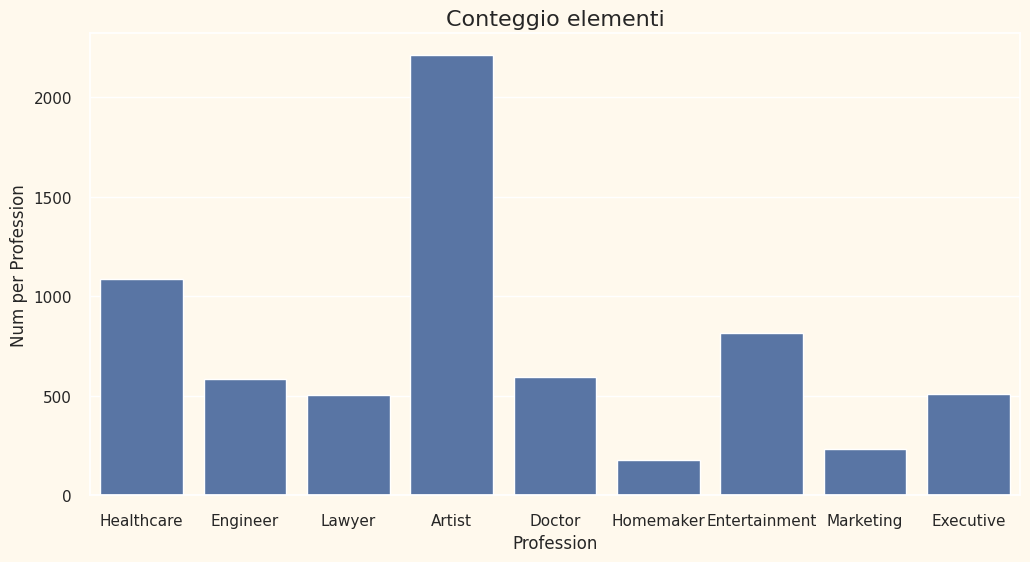

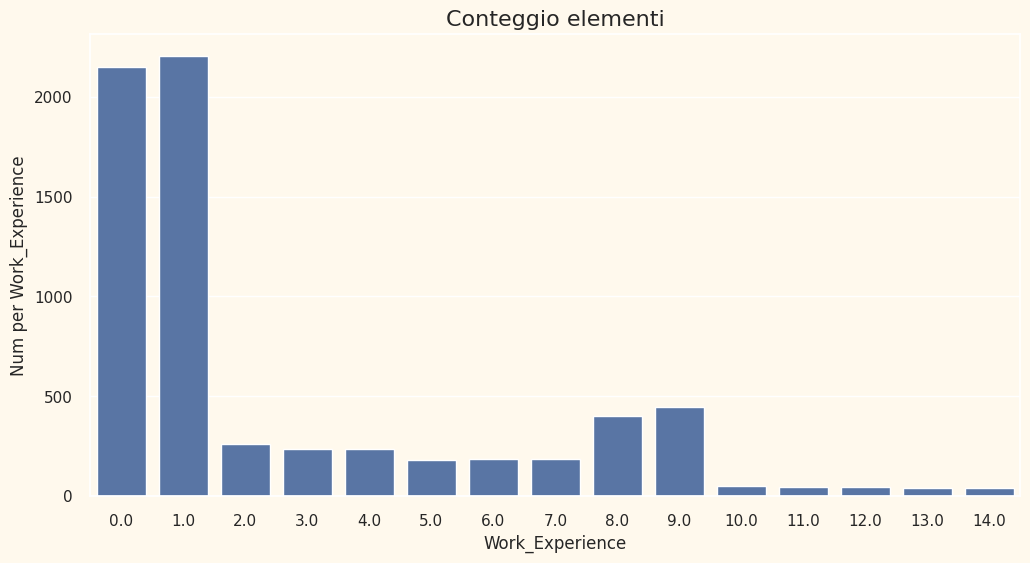

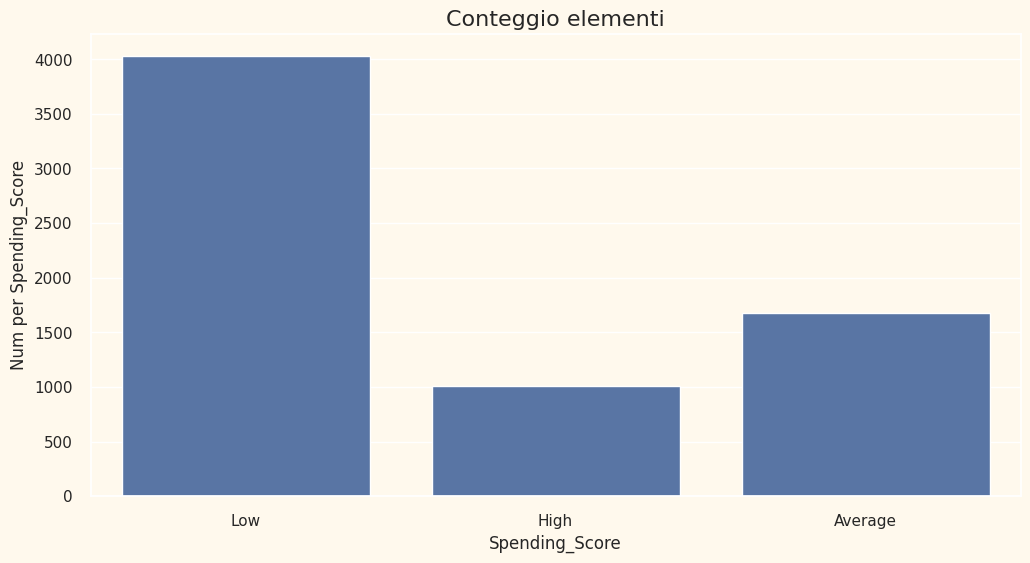

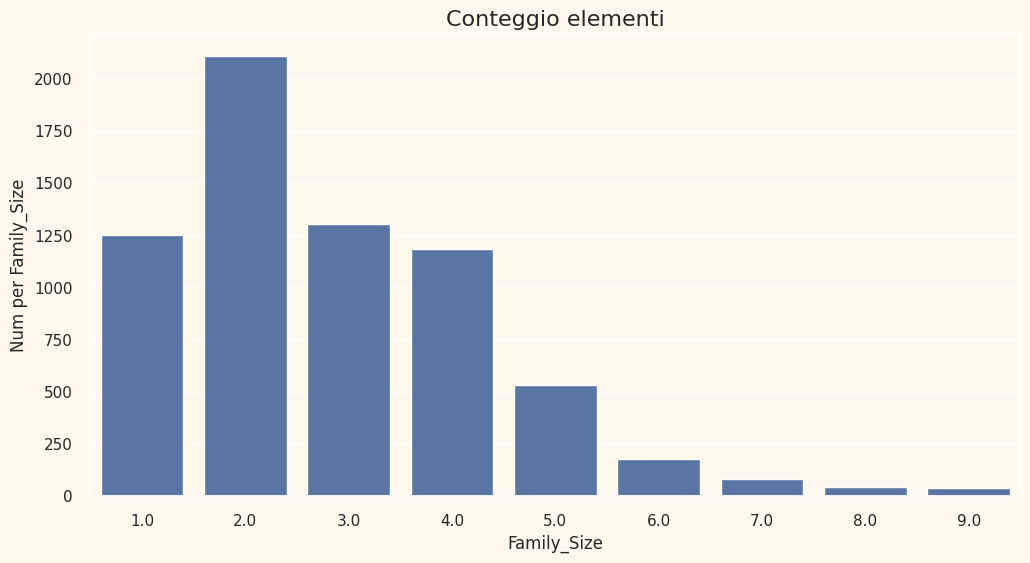

In [ ]:
for col in d.columns:
  plt.figure(figsize=(12, 6))
  sns.countplot(x=col, data=d)
  plt.xlabel(col)
  plt.ylabel('Num per '+col)
  plt.title('Conteggio elementi', size=16)

ulteriori analisi e visualizzazioni saranno effettuate dopo l'assegnazione dei cluster

Mi salvo questi dati su una nuova df variable, così poi dopo il clustering ci aggiungo una colonna con il relativo cluster. Con d non lo faccio perchè di seguito si farà l'encoding e lo scaling dei dati

In [11]:
dwc=d.copy() #data with cluster
dwc.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
5,Male,Yes,56,No,Artist,0.0,Average,2.0
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0


trasformo le feature categoriche in numeriche, visto che mi serve per il modello di clustering e lo voglio anche per vedere i coefficienti di correlazione

In [12]:
s = (d.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']


In [13]:
LE=LabelEncoder()
for i in object_cols:
    d[i]=d[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [15]:
d.head() #vedo infatti che le features ora sono tutte numeriche

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0,22,0,5,1.0,2,4.0
2,0,1,67,1,2,1.0,2,1.0
3,1,1,67,1,7,0.0,1,2.0
5,1,1,56,0,0,0.0,0,2.0
6,1,0,32,1,5,1.0,2,3.0


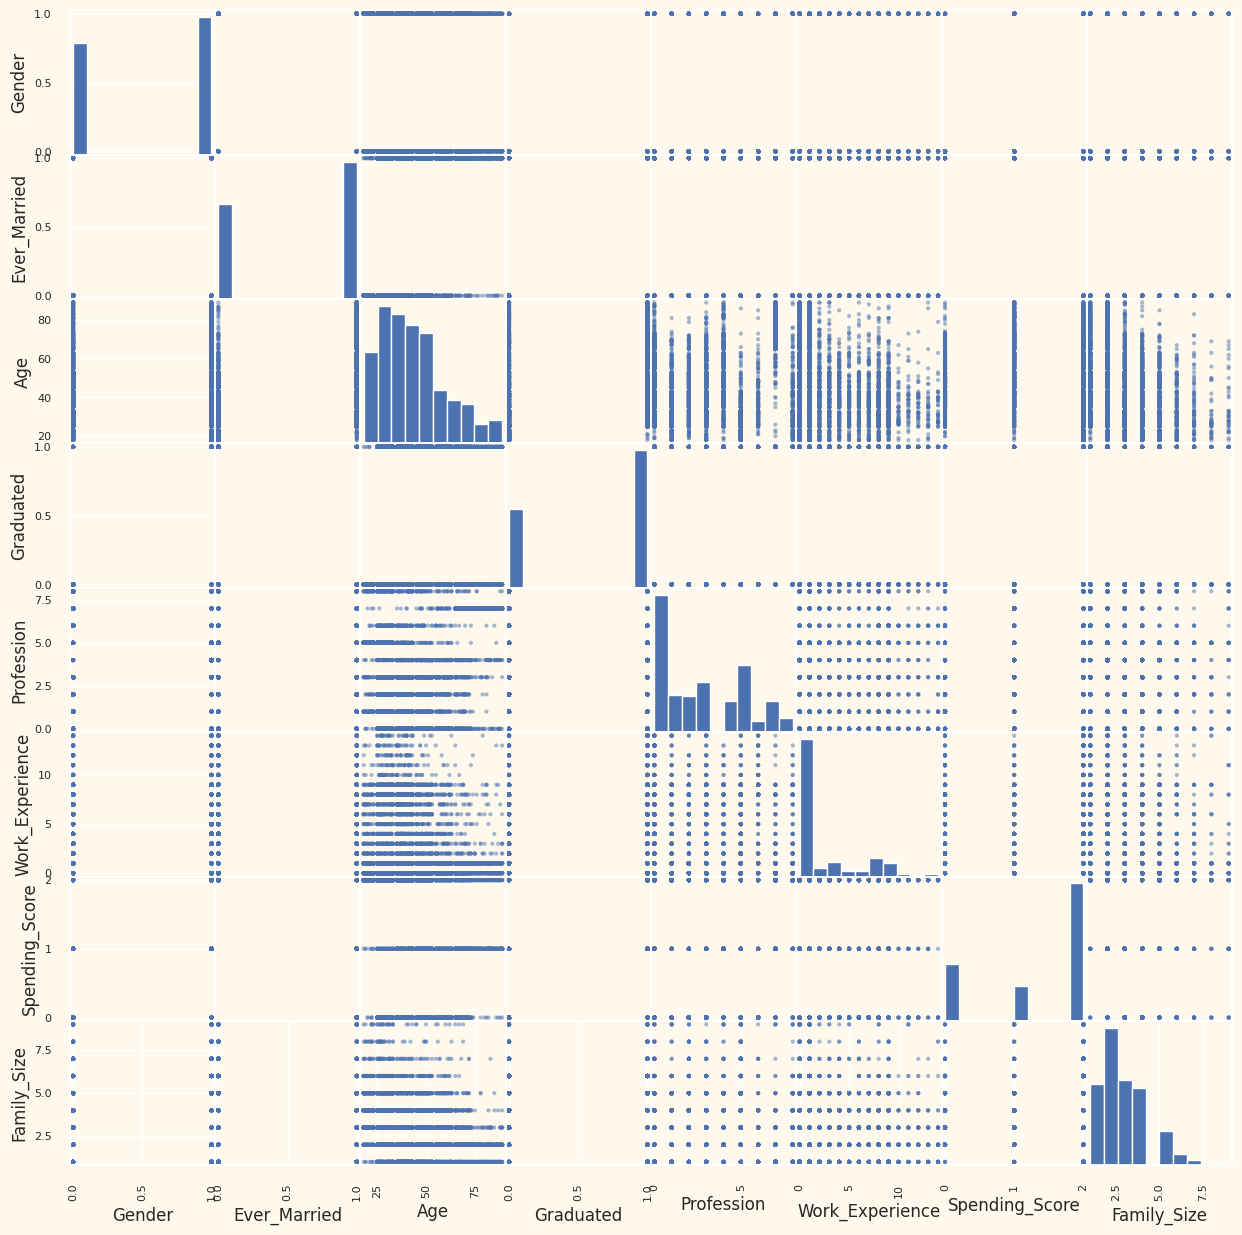

In [ ]:
pd.plotting.scatter_matrix(d, figsize=(15,15))
plt.show()

Text(0.5, 1.0, 'Pairplot delle  features ')

<Figure size 1200x600 with 0 Axes>

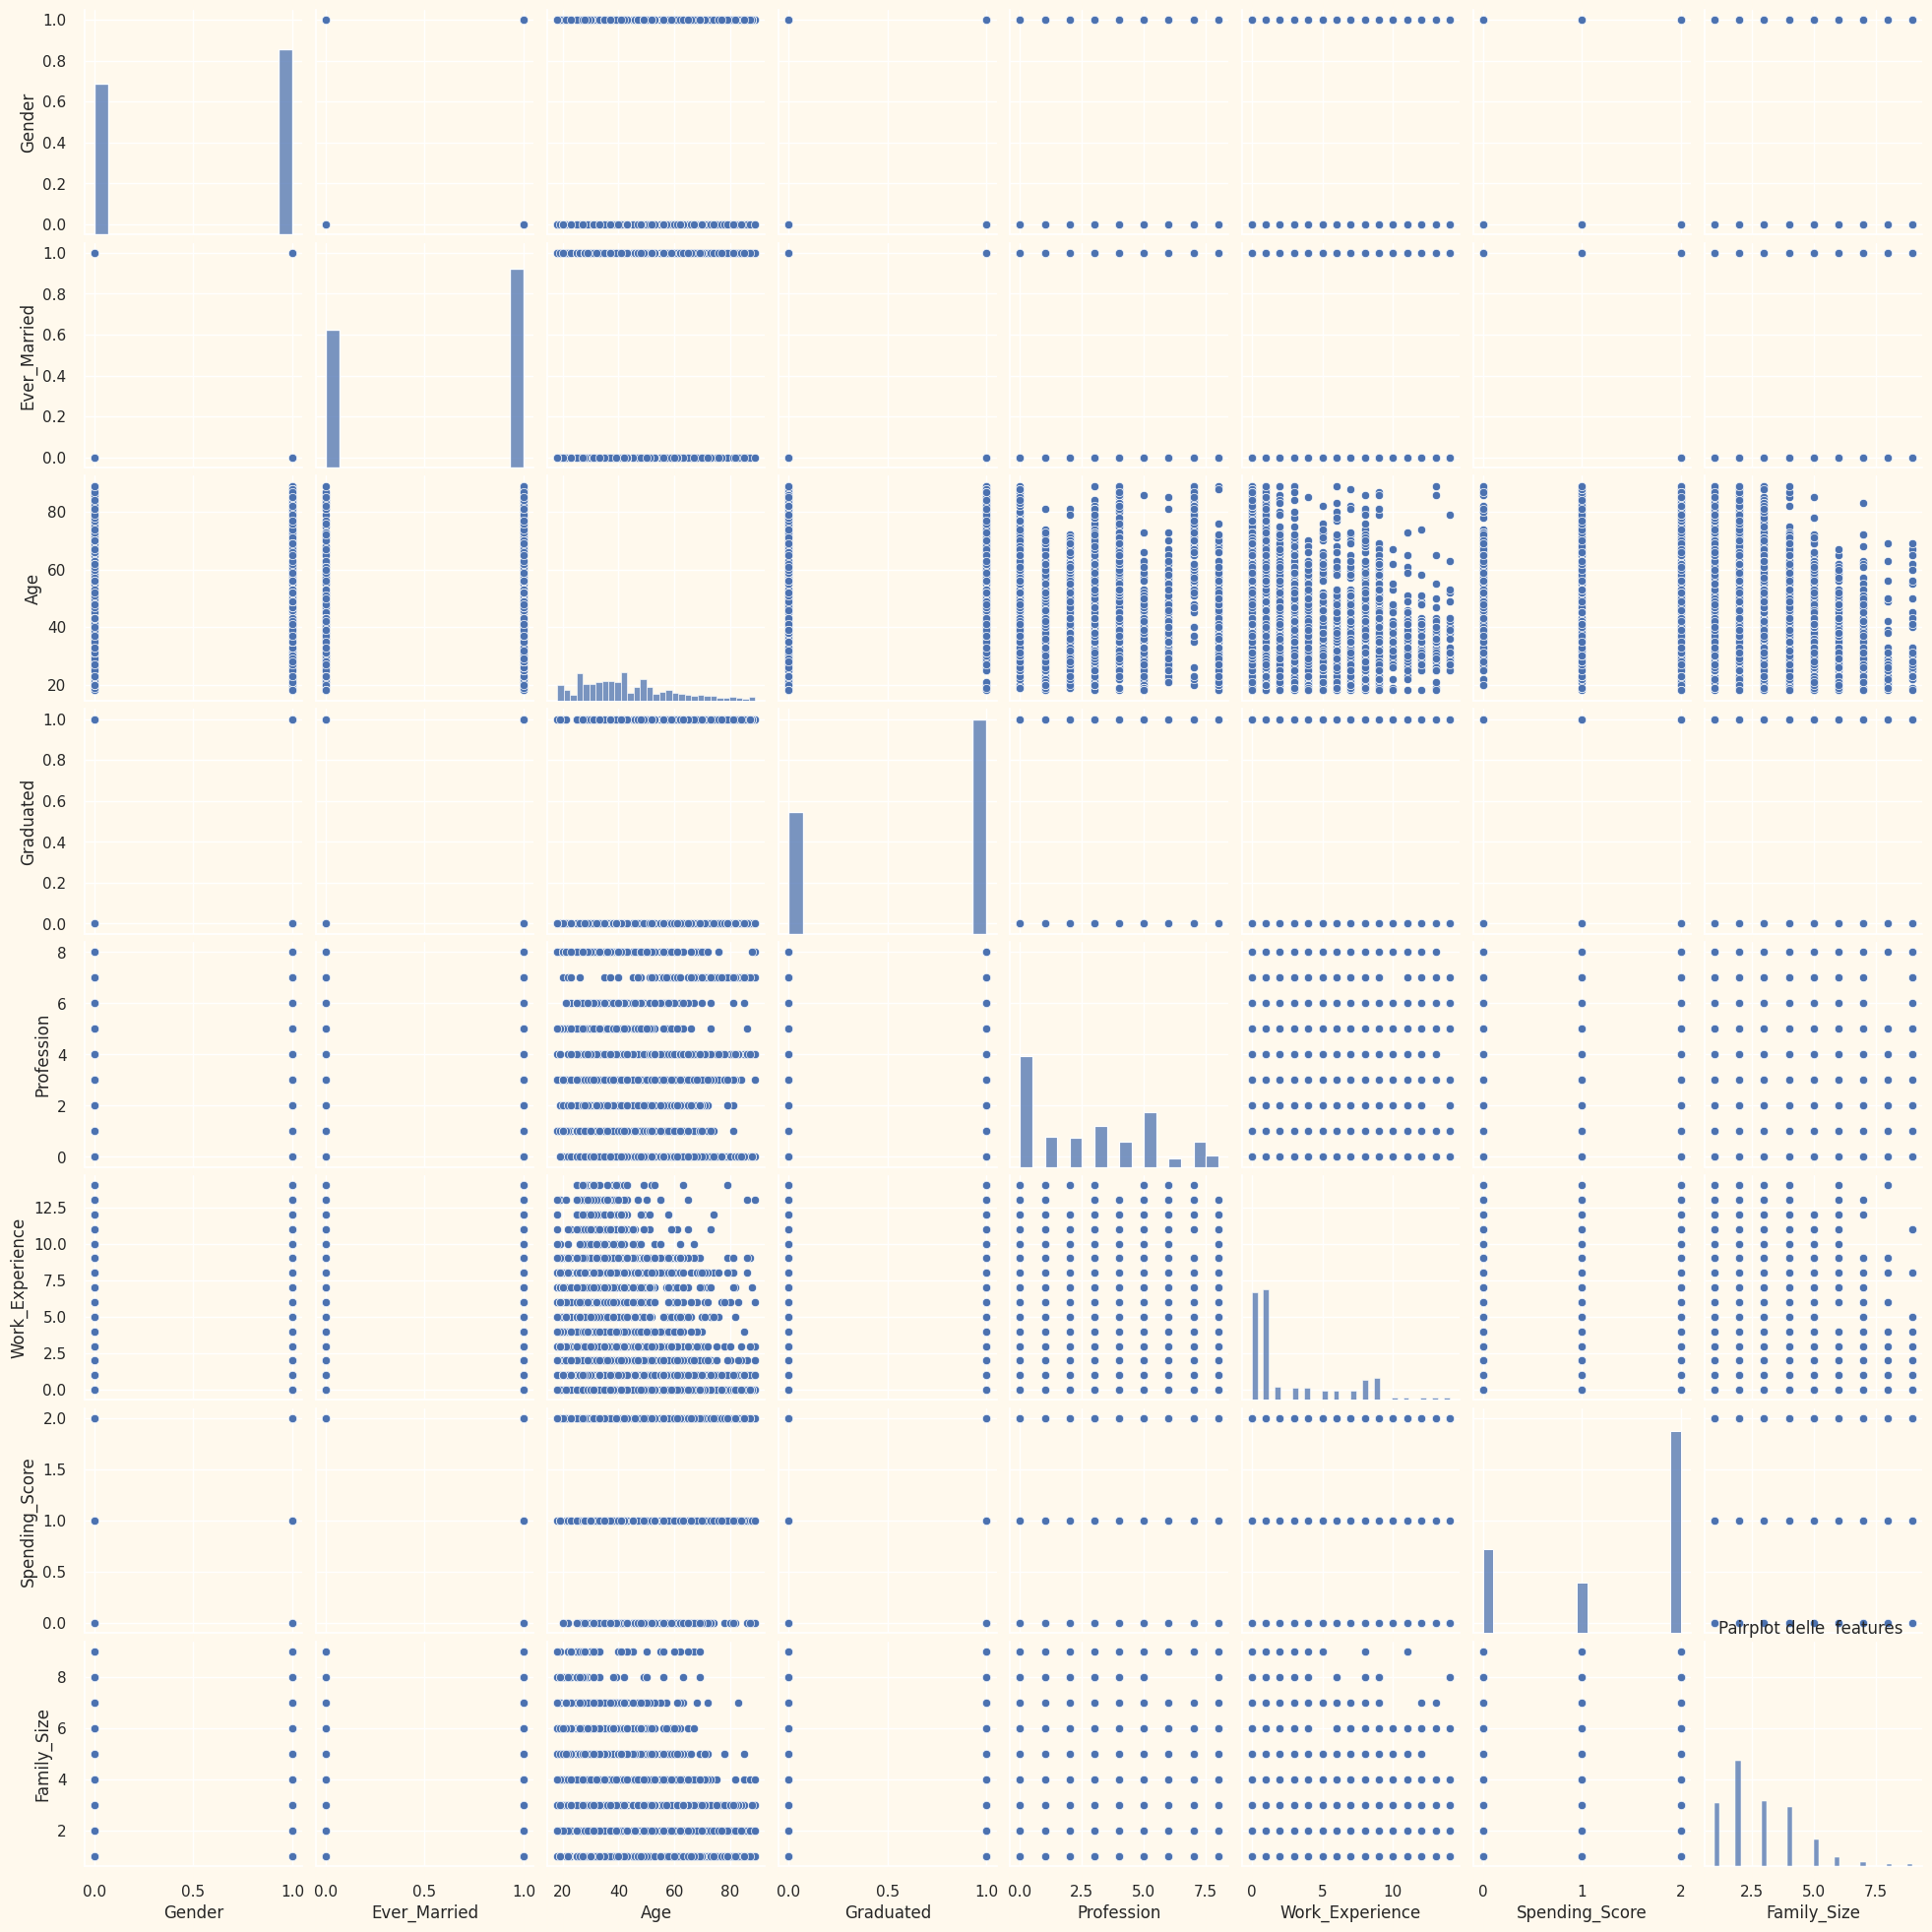

In [ ]:
plt.figure(figsize=(12, 6))
sns.pairplot(data=d)
plt.title('Pairplot delle  features ')

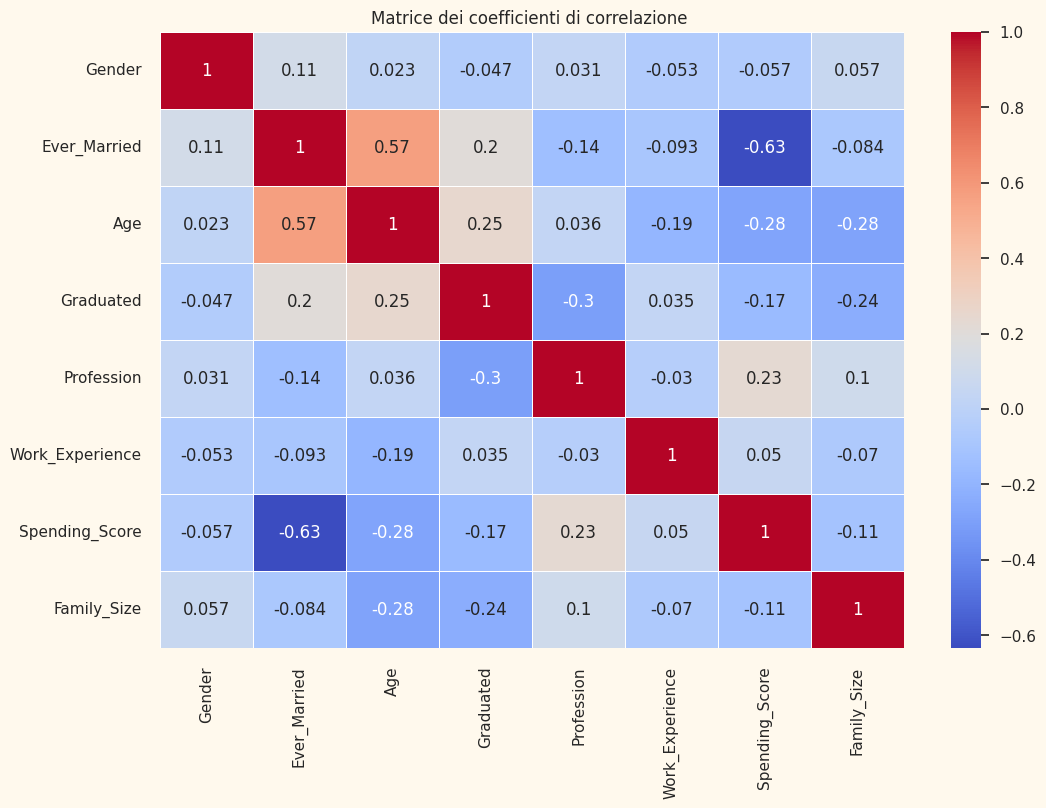

In [ ]:
correlation_matrix = d.corr() #calcola i coefficienti
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice dei coefficienti di correlazione ')
plt.show()

In [16]:
#scaling dei dati con variabile ds
ds=d.copy()
ds.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,0,22,0,5,1.0,2,4.0
2,0,1,67,1,2,1.0,2,1.0
3,1,1,67,1,7,0.0,1,2.0
5,1,1,56,0,0,0.0,0,2.0
6,1,0,32,1,5,1.0,2,3.0


In [17]:
#Scaling dei dati per avere migliori performance
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [18]:
#vediamo gli Scaled data
print("Dataframe usato per i successivi modelli modelli:")
scaled_ds.head()

Dataframe usato per i successivi modelli modelli:


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0.902604,-1.203804,-1.303562,-1.324114,0.912982,-0.478692,0.762325,0.760391
1,-1.107905,0.830700,1.421748,0.755222,-0.278357,-0.478692,0.762325,-1.209140
2,0.902604,0.830700,1.421748,0.755222,1.707208,-0.772431,-0.410671,-0.552630
3,0.902604,0.830700,0.755561,-1.324114,-1.072583,-0.772431,-1.583666,-0.552630
4,0.902604,-1.203804,-0.697937,0.755222,0.912982,-0.478692,0.762325,0.103881


DIMENSIONALITY REDUCTION

Per evitare la curse of dimensionality vediamo se possiamo ridurre il num di feauters con cui addestare i modelli senza perdere troppa informazione

vediamo prima i risultati con tutte e 8 le features


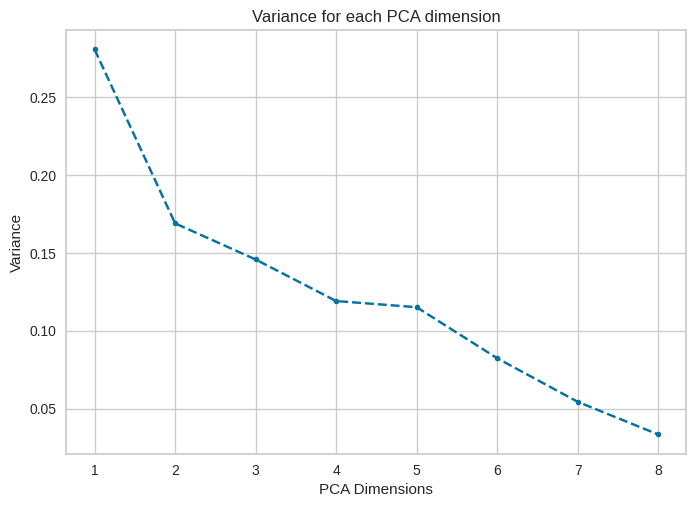

In [19]:

pca = PCA(8)
pca.fit(scaled_ds)
plt.plot(range(1,9),pca.explained_variance_ratio_,'o--', markersize=4)
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

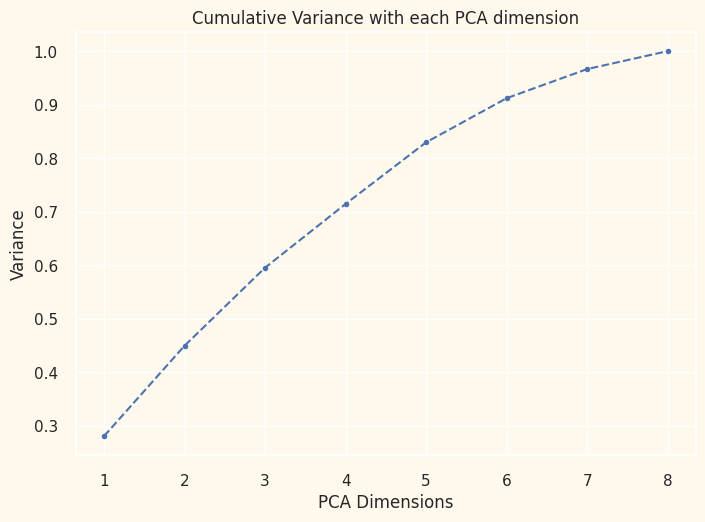

In [ ]:
#uguale ma cumulativo
plt.plot(range(1,9),pca.explained_variance_ratio_.cumsum(),'o--', markersize=4)
plt.title ('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

vediamo se abbiamo buoni risultati con 3 features , in modo tale che si possa poi fare una visualizzazione 3D

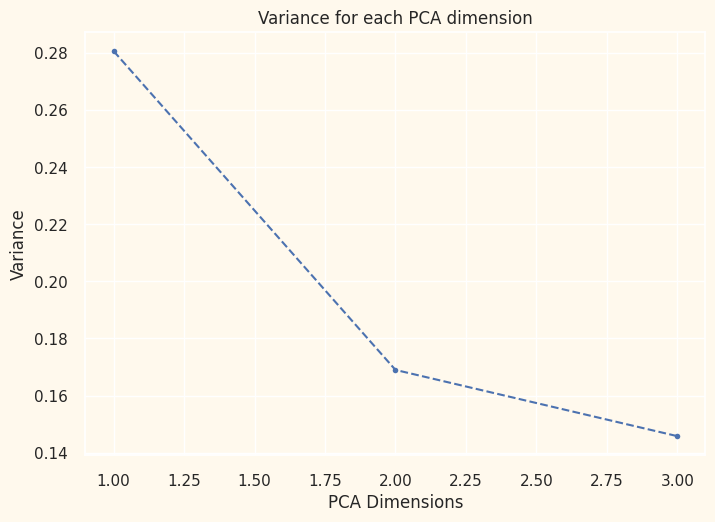

In [ ]:
pca = PCA(3)
pca.fit(scaled_ds)
plt.plot(range(1,4),pca.explained_variance_ratio_,'o--', markersize=4)
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

In [20]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"])) #3 colonne come il parametro
PCA_ds.describe().T #serve per fare la trasposta per migliore visualizzazione in questo caso

,count,mean,std,min,25%,50%,75%,max
col1,6718.0,-5.288350e-17,1.498328,-3.087419,-1.295048,-0.269103,1.268517,3.304625
col2,6718.0,-6.874855e-17,1.162772,-3.385902,-0.788984,0.059284,0.827632,4.341337
col3,6718.0,2.115340e-17,1.080076,-3.219069,-0.738799,-0.073357,0.566205,3.394194


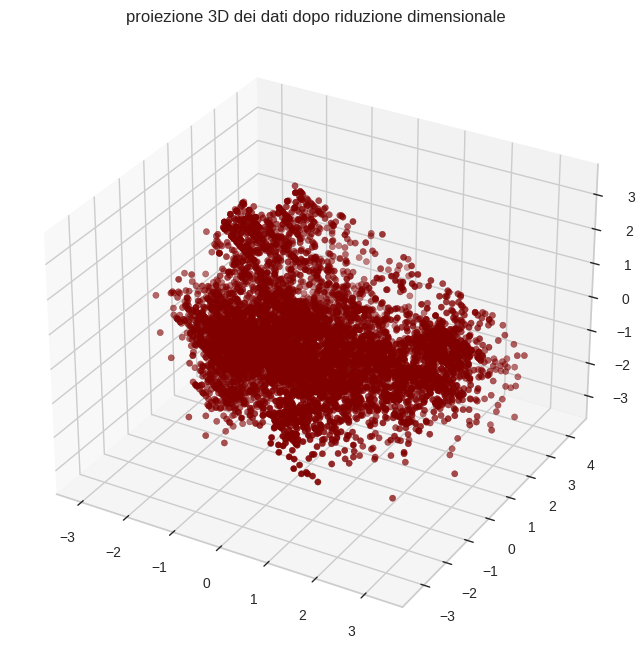

In [21]:
#proiezione in 3D con dimensioni ridotte a 3
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("proiezione 3D dei dati dopo riduzione dimensionale ")
plt.show()

CLUSTERING

Usiamo elbow method per vedere il numero ottimale di cluster con due algoritmi

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

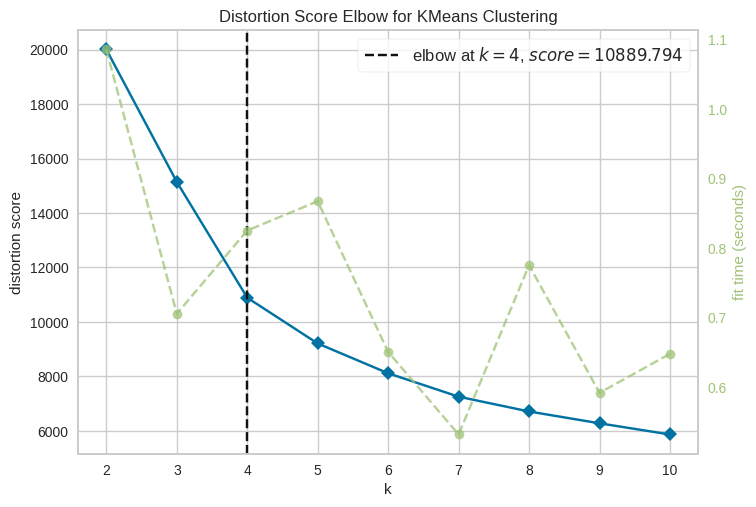

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10) #fa la prova fino a 10 cluster
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Elbow Method to determine the number of clusters to be formed:


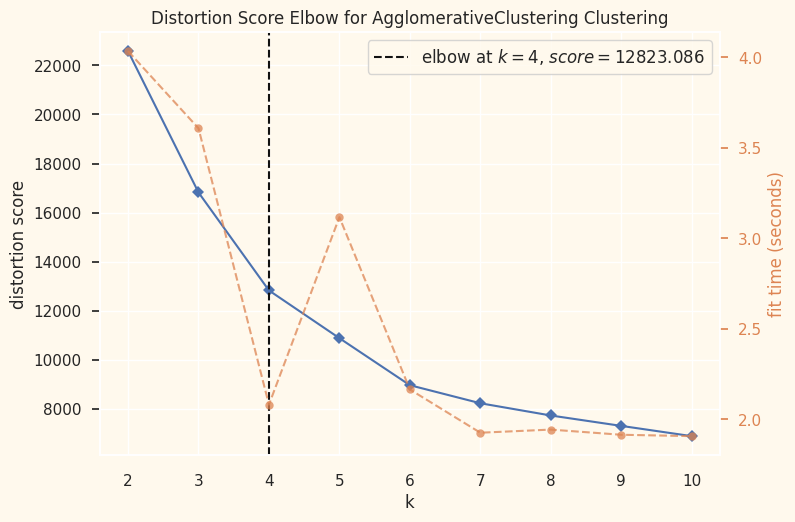

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(AgglomerativeClustering(), k=10) #fa la prova fino a 10 cluster
Elbow_M.fit(PCA_ds)
Elbow_M.show()

per entrambi il risultato migliore è con 4, pertanto procedo con individuare 4 cluster

In [23]:
AC = AgglomerativeClustering(n_clusters=4) #dichiaro il modello con il parametro

# fit e predict del modello, poi aggiungo la colonna del cluster
label_AC = AC.fit_predict(PCA_ds) #salvo le etichette che assegna a ciscuna variabile
PCA_ds["Clusters"] = label_AC

#aggiungo la colonna del cluster anche al dataframe di partenza che avevo ripulito dai dati mancanti
dwc["Clusters"]= label_AC

ora rivedo i dati iniziali con la variabile dwc : ho i dati puliti , non scalati e con features sia numeriche che categoriche e in aggiunta la colonna che rappresenta il cluster appena identificato

In [25]:
dwc.head() #vedo che è stata messa la colonna clusters

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Clusters
0,Male,No,22,No,Healthcare,1.0,Low,4.0,2
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,1
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,3
5,Male,Yes,56,No,Artist,0.0,Average,2.0,0
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0,1


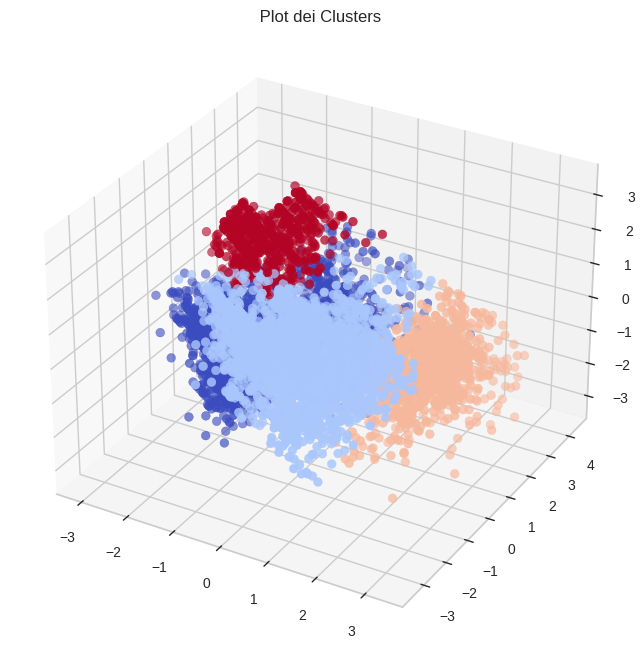

In [27]:
#Plotting in 3D dei cluster appena individuati per vedere graficamente come sono stati individuati e valutare i risultati (buoni a livello visuale)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = 'coolwarm' ) #uso PCA_ds con 3 colonne oltre a quella del cluster ; x y z definite appositamente poche celle prima
ax.set_title(" Plot dei Clusters")
plt.show()

ANALISI DEI RISULTATI

Dopo aver individuato i cluster facciamo una visualizzazione di alcune informazioni e caratteristiche del df iniziale in base ai cluster

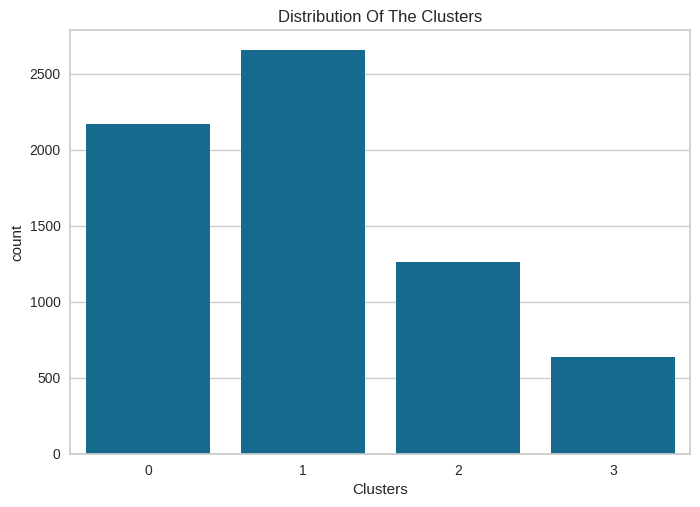

In [29]:
#Plotting della distribuzione dei cluster

pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=dwc["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

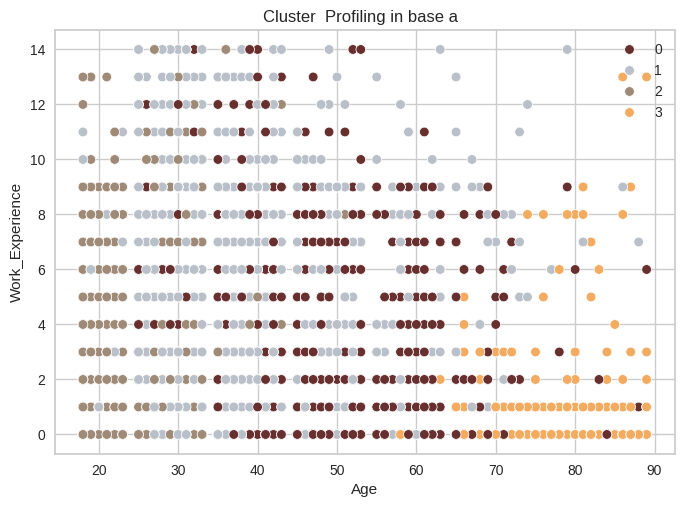

In [32]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.scatterplot(data = data,x=dwc["Age"], y=dwc["Work_Experience"],hue=dwc["Clusters"],palette= pal)
pl.set_title("Cluster  Profiling in base a  ")
plt.legend()
plt.show()

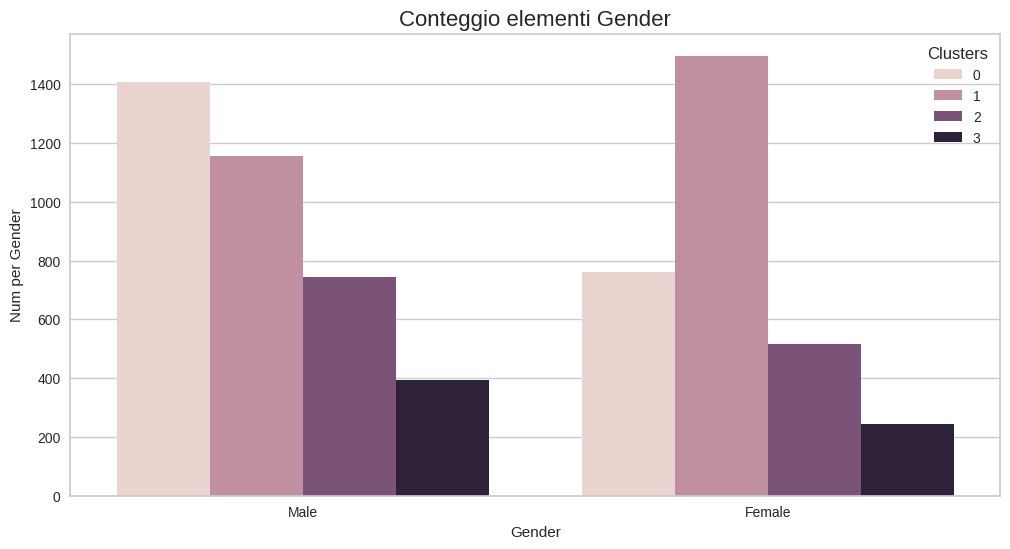

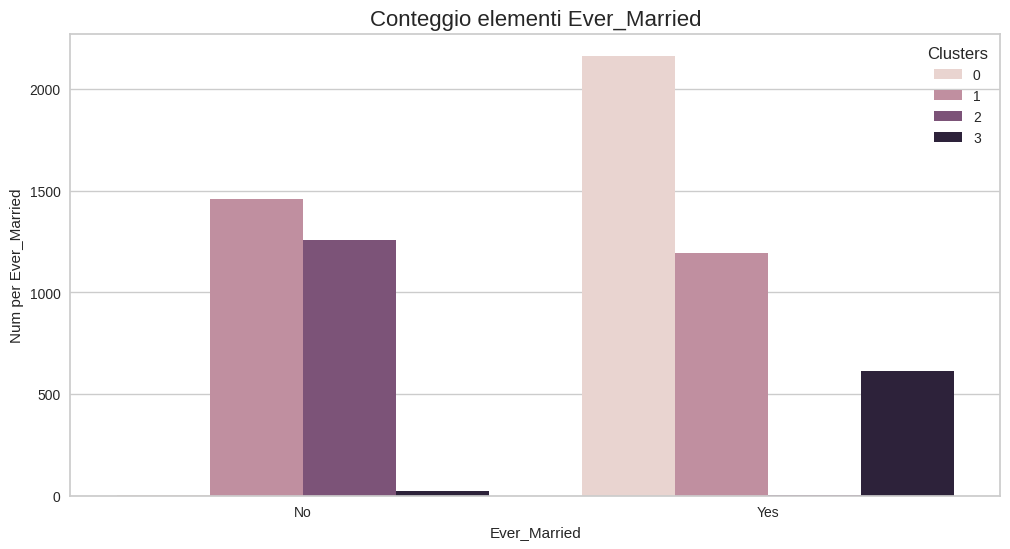

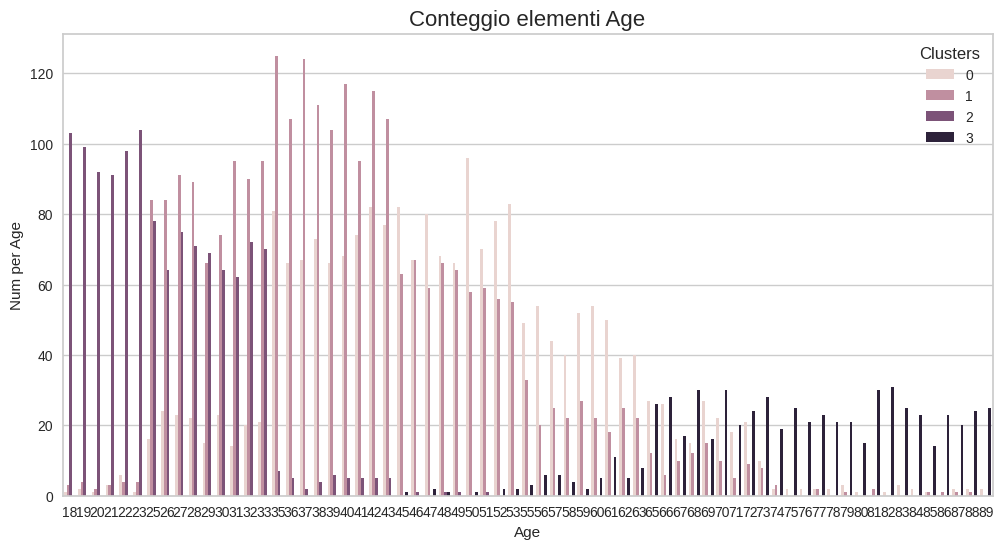

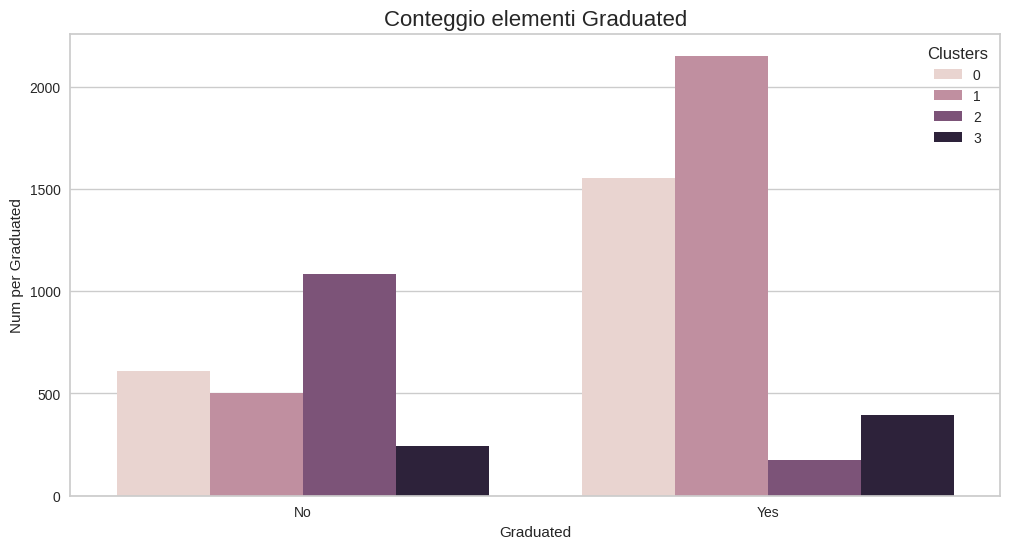

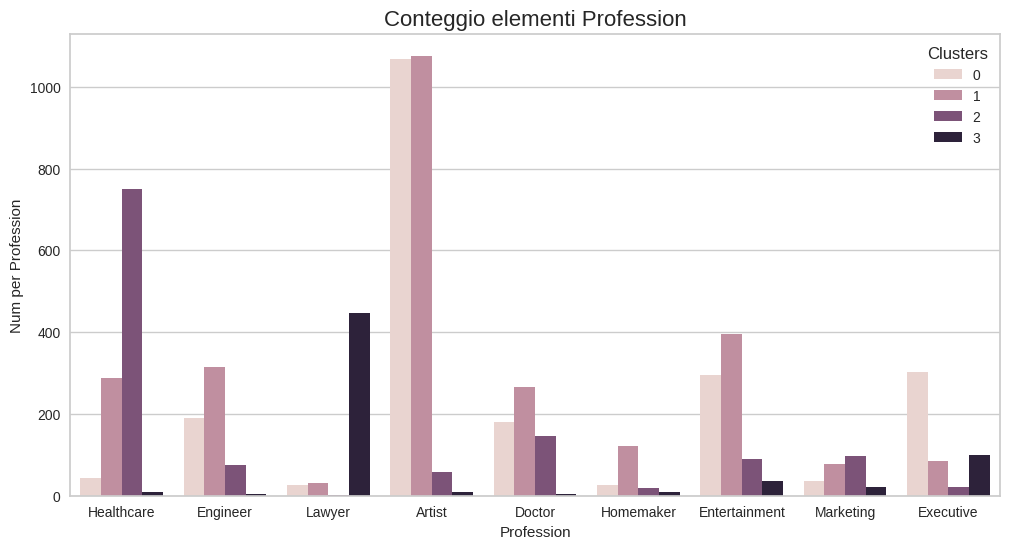

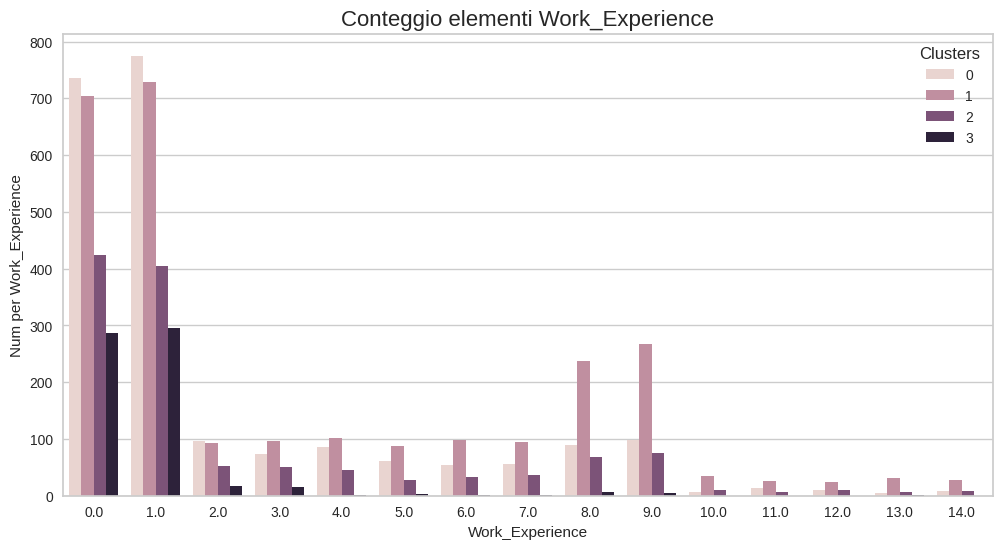

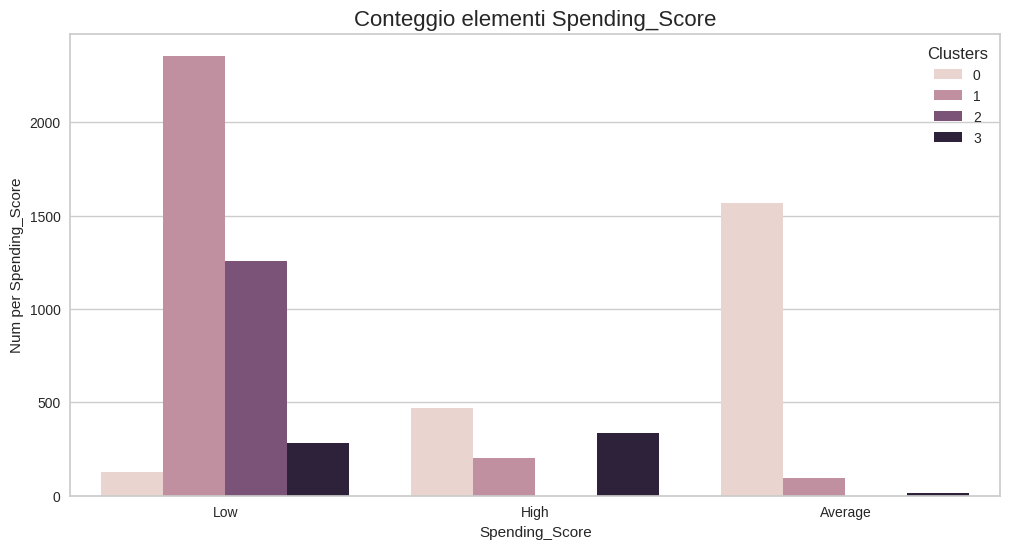

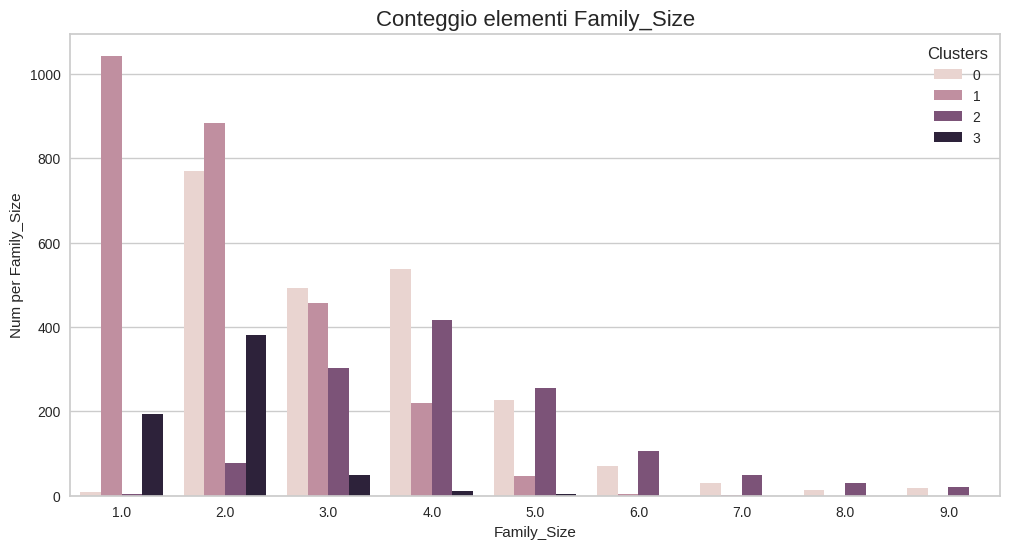

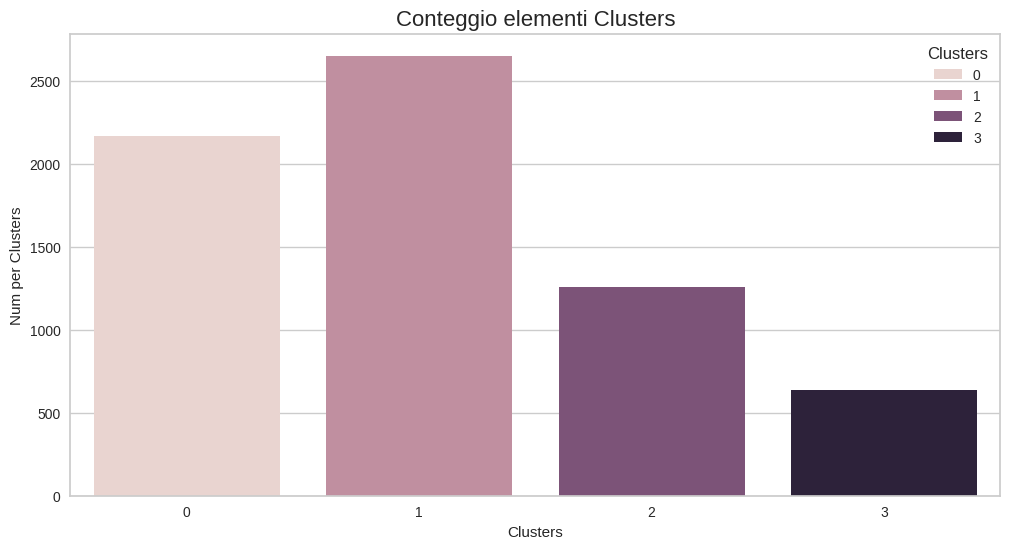

In [38]:
for col in dwc.columns:
  plt.figure(figsize=(12, 6))
  sns.countplot(x=col, data=dwc,hue=dwc["Clusters"])
  plt.xlabel(col)
  col=str(col) #per metterla nel titolo
  plt.ylabel('Num per '+col)
  title='Conteggio elementi '+col #metto il nome della colonna nel titolo
  plt.title(title, size=16)

Alcune tendenze in base alle visualizzazioni:

*  gender

 cluster sono uniformi

*   Matrimonio

 - cluster 0  sposati
 - cluster 1 equamente divisi
 - cluster 2 principalmente non sposati
 - cluster 3 sposati



*   Age

 - cluster 0  tra 30 e 60
 - cluster 1 tra 20 e 30
 - cluster 2 under 30
 - cluster 3 over 60

*   Graduated

 - cluster 0  più si che no
 - cluster 1 decisamente si
 - cluster 2 più no che sì
 - cluster 3 simili

*   work experience

 - cluster 0  quasi tutti inferiori a 2 anni
 - cluster 1 maggioranza inferiore a 2 anni ma parte considerevole intorno 8-9 anni
 - cluster 2 quasi tutti inferiori a 2 anni
 - cluster 3 quasi tutti inferiori a 2 anni


 *   Spending score

  - cluster 0  media
  - cluster 1 bassa
  - cluster 2 bassa
  - cluster 3  bilanciata alta e bassa

 *   family size

  - cluster 0  tra 2 e 5
  - cluster 1 minore 3
  - cluster 2 tra 3 e 5
  - cluster 3  al max 2


In base a queste caratteristiche, l'azienda può puntare meglio i singoli target con appositi advertising e promozioni specifiche

Per le features numeriche vediamo meglio i boxplot

<ipython-input-43-06adc9d45ce6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=dwc["Work_Experience"],x=dwc["Clusters"], palette= pal)


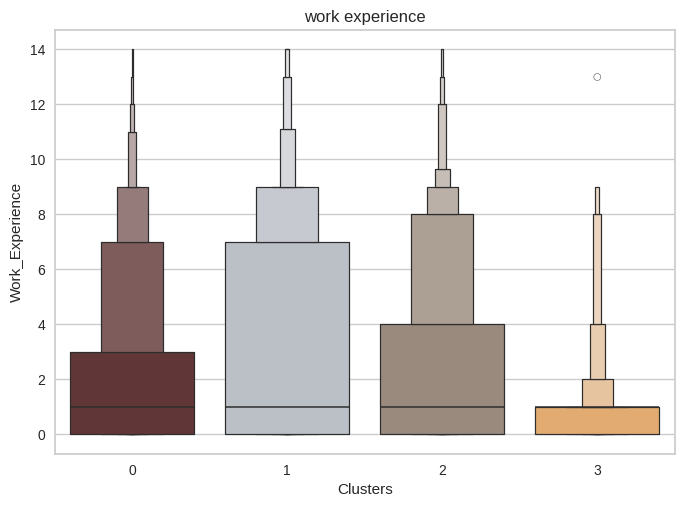

In [43]:
plt.figure()
pl=sns.boxenplot(y=dwc["Work_Experience"],x=dwc["Clusters"], palette= pal)
pl.set_title("work experience")
plt.show()

<ipython-input-44-8b2ba2fdd499>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=dwc["Family_Size"],x=dwc["Clusters"], palette= pal)


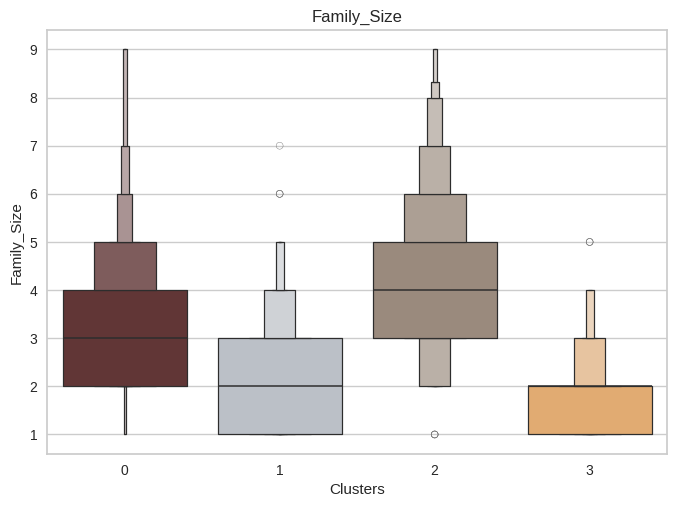

In [44]:
plt.figure()
pl=sns.boxenplot(y=dwc["Family_Size"],x=dwc["Clusters"], palette= pal)
pl.set_title("Family_Size")
plt.show()

<ipython-input-50-5987df750028>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=dwc["Age"],x=dwc["Clusters"], palette= pal)


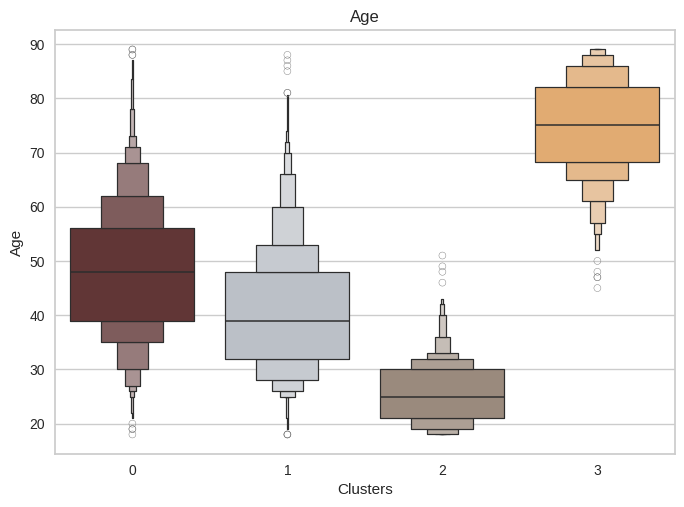

In [50]:
plt.figure()
pl=sns.boxenplot(y=dwc["Age"],x=dwc["Clusters"], palette= pal)
pl.set_title("Age")
plt.show()

RIFLESSIONI

Il task di data mining effettuato poteva essere la classificazione dello spending score piuttosto che il clustering? Sicuramente era un'altra valida area di studio; tuttavia il clustering in questo caso ci fornisce informazioni ulteriori rispetto alla calssificazione.

Ogni cluster , oltre ad avere una propria spending score predominante ,ci fornisce info ulteriori : per ogni feature vediamo l'aspetto principale del cluster di riferimento.
Essendo una clintela di casa automobilistica si può avere maggiore informazioni sul tipo di veicolo da proporre ( se ha famiglia numerosa meglio più grande) , sulla possibilità di accettare pagamenti con finanziamenti ( valutando la work experience: se lavora da più tempo ha maggiore patrimonio?), su quale segmento di mercato puntare maggiormente (in base al numero di elementi dei singoli cluster),ecc...